## How to look for LOOOONG periods in TESS using `lightkurve`

TESS is fantastic, but each sector is only 27 days long. This can make it hard to find long periods, even in cases where we have targets in the TESS CVZ. In this notebook we'll show how to extract long periods in TESS data with lightkurve

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt


# We'll need this later
def vstack(dms):
    """ Custom vertical stack script 
    """
    npoints = np.sum([dm.shape[0] for dm in dms])
    ncomps = np.sum([dm.shape[1] for dm in dms])
    X = np.zeros((npoints, ncomps))
    idx = 0
    jdx = 0
    for dm in dms:
        X[idx:idx+dm.shape[0], jdx:jdx+dm.shape[1]] = dm.X
        idx = idx + dm.shape[0]
        jdx = jdx + dm.shape[1]
    prior_mu = np.hstack([dm.prior_mu for dm in dms])
    prior_sigma = np.hstack([dm.prior_sigma for dm in dms])
    name = dms[0].name
    return lk.DesignMatrix(X, name=name, prior_mu=prior_mu, prior_sigma=prior_sigma)

First off, we need all the data for a single target. Here I'm choosing a 2 minute target, but this will work with an FFI target just fine!

In [2]:
sr = lk.search_targetpixelfile('TIC 150428135', mission='tess')

In [3]:
tpfs = sr.download_all()

Let's take a look at the raw light curve.

In [4]:
raw_lc = lk.LightCurveCollection([tpf[np.isfinite(tpf.flux_bkg.sum(axis=(1, 2)))].to_lightcurve() for tpf in tpfs]).stitch()

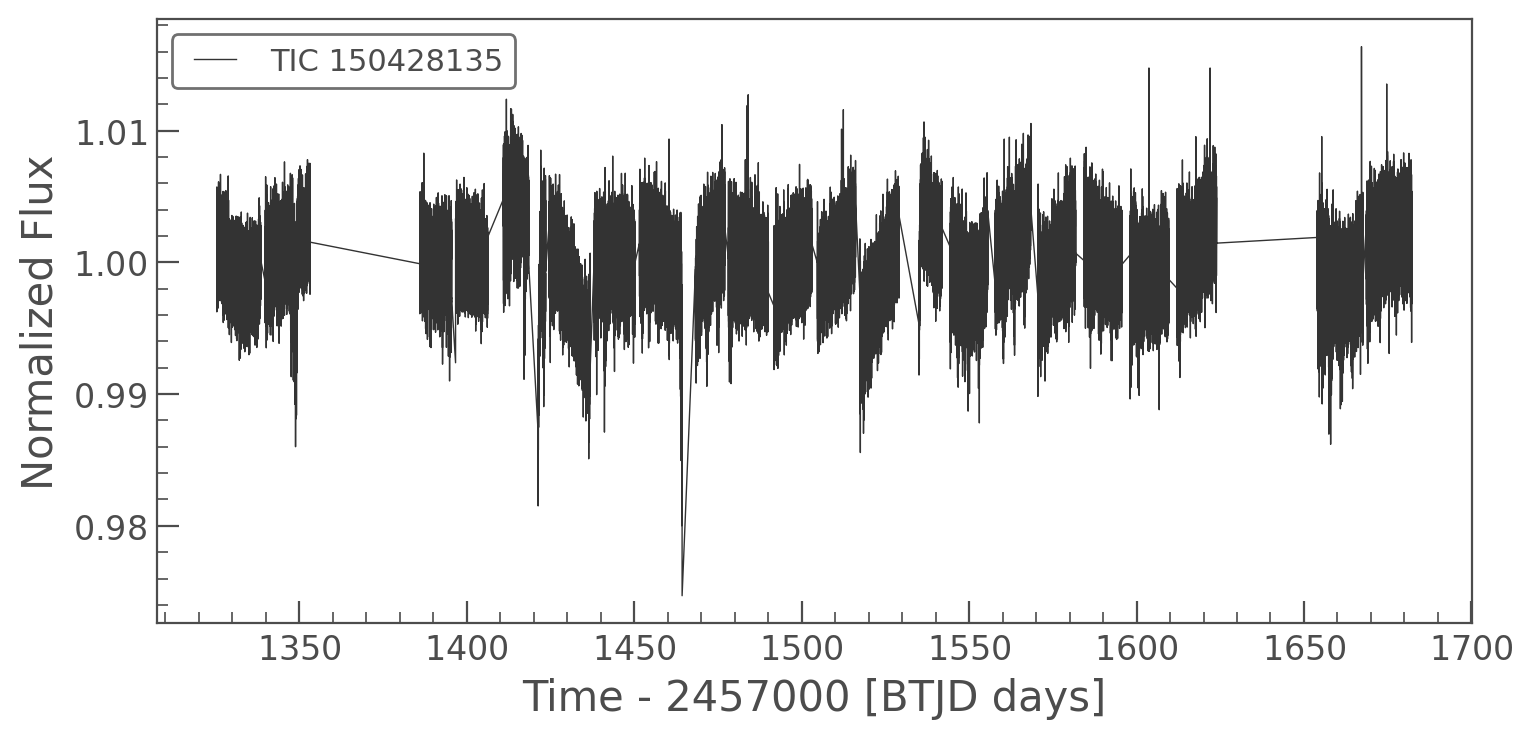

In [5]:
raw_lc.plot()

Wow, that looks pretty choppy. Maybe there's a long term rotation in there, but it's been washed out by all the corrections applied to remove the background.

So, to find long period rotation, we need to add the background back in. This is a SPOC light curve, where background has been removed by the TESS pipeline. But, this might have overcorrected the long period rotation, so we need to add it back in. We can do this with `lightkurve`:

In [6]:
tpfs_uncorr = [(tpf + np.nan_to_num(tpf.flux_bkg)) for tpf in tpfs]

This is now a list of tpfs, with the TESS scattered light model from the pipeline added back in. Great! We also need to get rid of any "nan" times:

In [7]:
tpfs_uncorr = [tpf[np.isfinite(tpf.flux.sum(axis=(1, 2)))] for tpf in tpfs_uncorr]

Great, now let's sum them up into a light curve!

In [8]:
# Our light curve
lc = lk.LightCurveCollection([tpf.to_lightcurve() for tpf in tpfs_uncorr]).stitch()

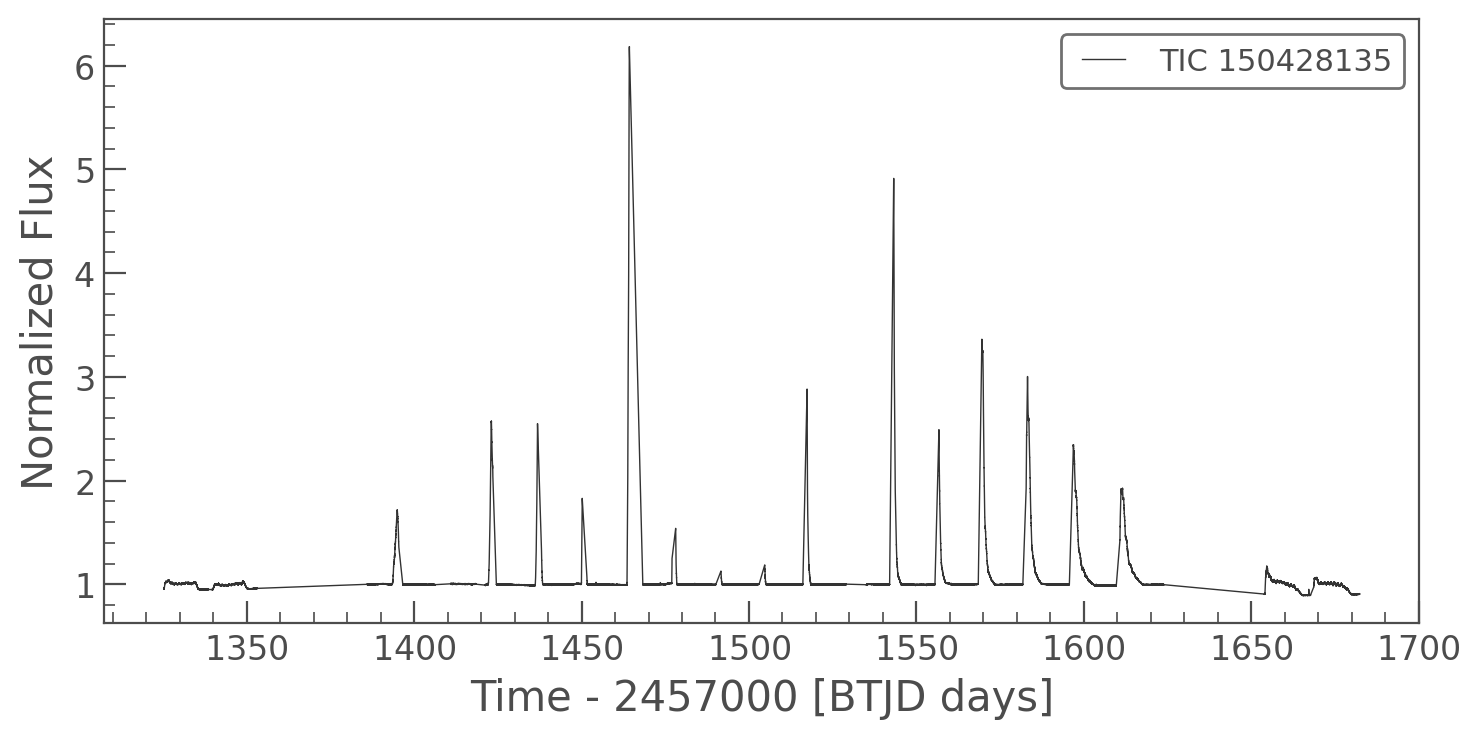

In [9]:
lc.plot()

Ok, this light curve has a lot going on. There are 11 sectors of data in this light curve! Each sector has a break in the middle for the data downlink. Now, we're going to build a simple model for the background in each of the TPFs.

This simple model is just the first three *Principle Components* of the pixels that aren't inside the aperture (i.e. that aren't on our target).

In [10]:
#Note there is a verbose lightkurve warning about "rank" when we set up the matrix in this way, I'm silencing it.
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore', lk.LightkurveWarning)    
    bkgs = []
    for tpf in tpfs_uncorr:
        # Find the pixels outside of the optimum aperture
        pixels = tpf.flux[:, ~tpf.pipeline_mask]
        # Create a "design matrix" out of them
        bkg_dm = lk.DesignMatrix(pixels, name='bkg')
        # Take the top three principle components
        bkg_dm = bkg_dm.pca(3)
        # Add a constant "offset" term to allow each part of the design matrix to 
        bkg_dm = bkg_dm.append_constant()
        bkgs.append(bkg_dm)

Great, now we have design matrices for the background pixels in every sector.

In [11]:
bkgs

[bkg DesignMatrix (18104, 4),
 bkg DesignMatrix (13452, 4),
 bkg DesignMatrix (15803, 4),
 bkg DesignMatrix (17894, 4),
 bkg DesignMatrix (14835, 4),
 bkg DesignMatrix (16362, 4),
 bkg DesignMatrix (13427, 4),
 bkg DesignMatrix (17257, 4),
 bkg DesignMatrix (18085, 4),
 bkg DesignMatrix (18551, 4),
 bkg DesignMatrix (19583, 4)]

Each design matrix has a `prior_mu` and `prior_sigma` attribute. These are the expected mean and variance of each component we're going to fit. You can think of these like "guesses" for the weight of component. In this case, we know that the offset for each sector should be around 1, because our light curve is normalized. So we can put a weak prior on the offset term being around 1.

In [12]:
for bkg in bkgs:
    bkg.prior_mu[-1] = 1
    bkg.prior_sigma[-1] = 0.1

Now, we're going to split each component at the data downlink. Right now, each half of the sector is being fit at the same time, but if we break the design matrices up, we'll be able to fit the first half separately from the second half of the sector. We do that below:

In [13]:
# Split at the downlink
bkgs = [bkg.split(list((np.where((np.diff(tpf.time) > 0.3))[0] + 1))) for bkg, tpf in zip(bkgs, tpfs_uncorr)]

Now we need to stack all these design matrices together! We need to vertically stack them. 

In [14]:
bkgs[0]

bkg DesignMatrix (18104, 8)

Each design matrix has a number of time points, and 8 components in it. (3 pca components and 1 offset component per each HALF of the sector.)

We can't just vertically stack them normally, they all have unique shapes. We need to stack them in array that has shape **total number of time points** by **total number of components**. I've made a custom script to do this for us.

In [15]:
systematics_dm = vstack(bkgs)

In [16]:
systematics_dm

bkg DesignMatrix (183353, 92)

Awesome, `systematics_dm` is now a huge design matrix with every point in time, and 92 total components.

Now, we just need a design matrix for the star. This could be any model for the stellar variability, but we're going to use a basis spline. This comes already packaged in `lightkurve`, all we need to do is tell `lightkurve` where we want to place "spline knots". You should space the knots approximately as far apart as $\lesssim$25% of the period of the signal you're searching for.

In [17]:
n_knots = int(lc.time[-1] - lc.time[0])//10

In [18]:
# Create a spline design matrix
star_dm = lk.designmatrix.create_spline_matrix(lc.time,
                                               knots=list(np.linspace(lc.time[0], lc.time[-1], n_knots)))

This is great! Unfortunately, some of those knots fall in gaps. We can remove components from this design matrix where there's no data using the following:

In [19]:
star_dm = lk.DesignMatrix(star_dm.X[:, star_dm.X.sum(axis=0) != 0], name='spline')

Now, we can add in some priors for the star design matrix. Here I've specified that the components should average to somewhere close to zero (remember, the systematics design matrix has the offset terms) and that `prior_sigma` is small. That is to say, that it shouldn't be very variable. Changing these values may have a significant impact on the trend you find, so watch out!

In [20]:
star_dm.prior_mu = np.zeros_like(star_dm.prior_mu)
star_dm.prior_sigma = np.zeros_like(star_dm.prior_sigma) + 0.001

Now we just stitch these two design matrices together

In [21]:
full_dm = lk.DesignMatrixCollection([systematics_dm, star_dm])

In [22]:
full_dm

DesignMatrixCollection:
	bkg DesignMatrix (183353, 92)
	spline DesignMatrix (183353, 37)

Now, that's a pretty big matrix. There are some ways to make this a little cheaper to calculate, but for now let's keep going.

All we have left to do is find the best fitting weights for this design matrix.

In [23]:
# Some of the errors ended up being "nans" because of pipeline reasons, this is a hacky fix for that
lc.flux_err[~np.isfinite(lc.flux_err)] = np.nanmedian(lc.flux_err)

In [24]:
# Make RegressionCorrector object
reg = lk.RegressionCorrector(lc)

# Pass in the design matrix
clc = reg.correct(full_dm)

That step might take a few seconds, but once it's finished you should have the corrected light curve. First, let's use `RegressionCorrector`'s `diagnose` method to take a look at the fit:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x14fb4f278>,
      dtype=object)

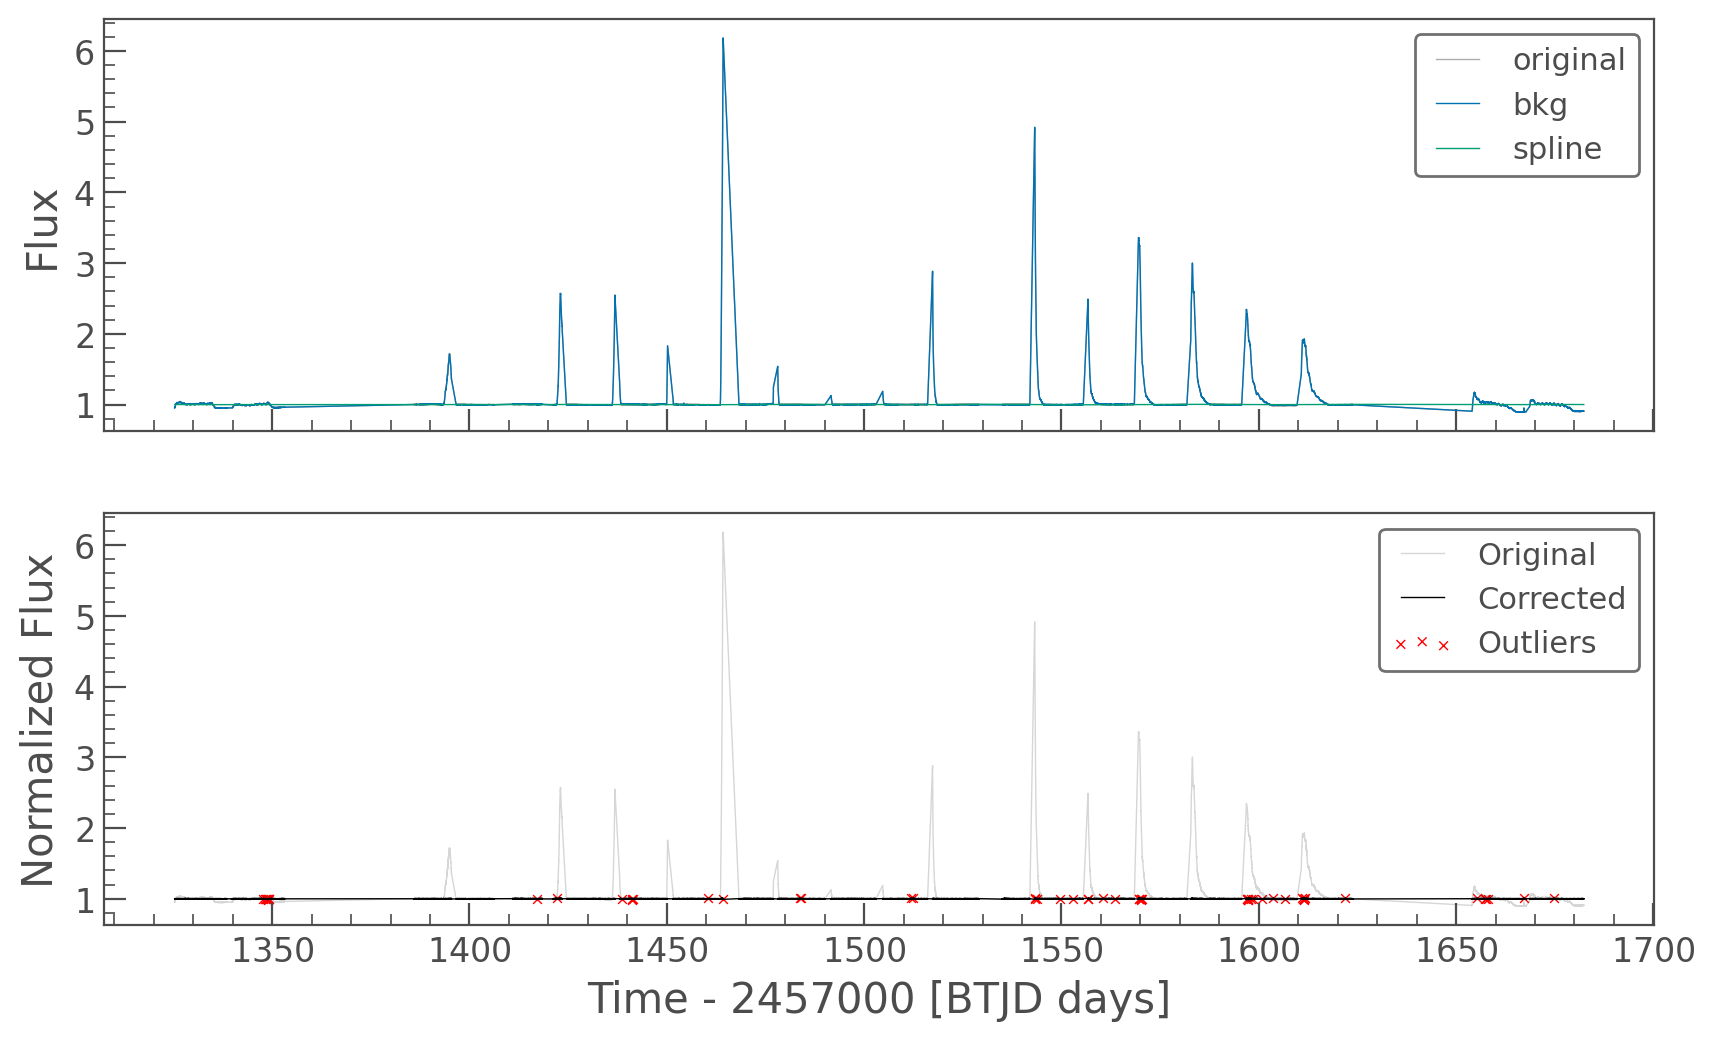

In [25]:
reg.diagnose()

This looks great! The bkg design matrix has fit all the scattered light and the spline design matrix is pretty flat! Let's take a look at the corrected light curve.

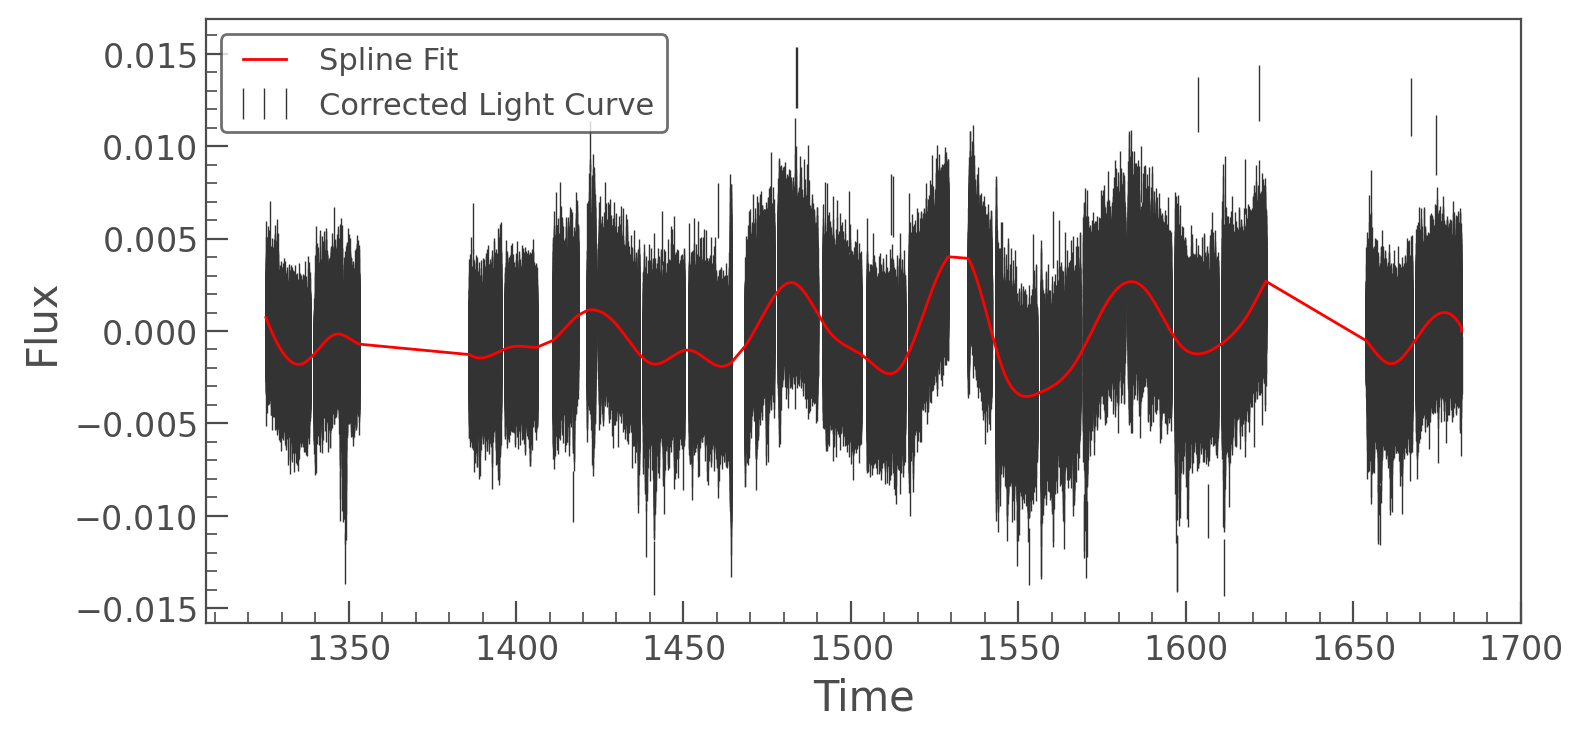

In [26]:
ax = (lc - reg.diagnostic_lightcurves['bkg']).errorbar(label='Corrected Light Curve')
reg.diagnostic_lightcurves['spline'].plot(ax=ax, c='r', lw=1, label='Spline Fit')

Wow! Looks like there's a significant rotation period in there! Remember, we never told the model there was a periodic signal, only a long term smooth signal. We can use a Lomb-Scargle Periodogram to look for periodicities in the data. Here, I'm fitting a Lomb-Scargle Periodogram to the spline light curve, because it's less noisy and has no short term variability in it.

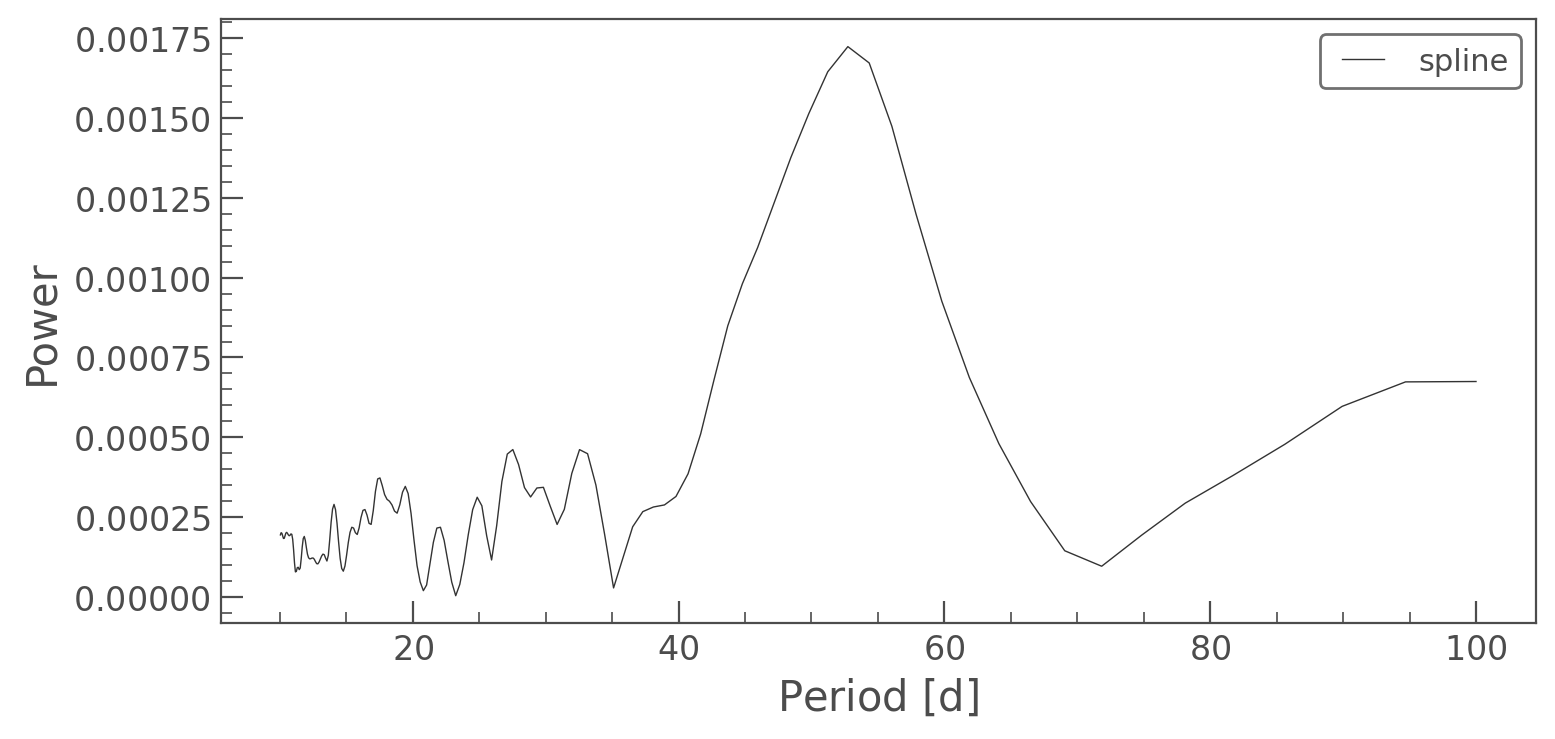

In [27]:
reg.diagnostic_lightcurves['spline'].to_periodogram(minimum_period=10, maximum_period=100).plot()